In [1]:
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from FER_model import *
from torchvision import transforms
import torch.utils.data as utils
from sklearn.model_selection import train_test_split
from tensorboardX import SummaryWriter
from PIL import Image
from matplotlib import pyplot as plt

# GPU 자원 사용확인
devices_id = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(
    devices_id
)  # fix bug for `ERROR: all tensors must be on devices[0]`

# Create Tensorboard SummaryWriter instance
writer = SummaryWriter('./FER_log/7layer')

In [2]:
fer_csv = '../data/FER+/fer2013.csv'

emotion_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy',
                4: 'sad', 5: 'surprise', 6: 'neutral'}

# Step 1. Load Dataset
def load_fer2013(fer_csv):
    data = pd.read_csv(fer_csv)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'), (48, 48))
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = data['emotion'].values
    return faces, emotions

# Step 1. Load Dataset
class EmotionDataset(utils.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index].reshape(48, 48)
        x = Image.fromarray((x))
        if self.transform is not None:
            x = self.transform(x)
        y = self.y[index]
        return x, y

# Step 1. Load Dataset
faces, emotions = load_fer2013(fer_csv)
# dataset 분할(train, validation)
train_X, val_X, train_y, val_y = train_test_split(faces, emotions, test_size=0.2, random_state = 1, shuffle=True)
avg_pixels = train_X.mean()
std_pixels = train_X.std()

# dataset augmentation
train_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=avg_pixels, std=std_pixels)
                    ])
val_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=avg_pixels, std=std_pixels)
                ])

# Step 1. Load Dataset
train_dataset = EmotionDataset(train_X, train_y, train_transform)
val_dataset = EmotionDataset(val_X, val_y, val_transform)

# Step 2. Make Dataset Iterable
batch_size = 100

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size)

In [3]:
# transforms 예제
before_trans = torch.from_numpy(faces[0])
before_trans = before_trans.squeeze()

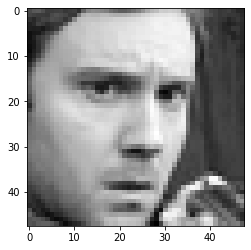

In [4]:
plt.imshow(before_trans, cmap='gray')

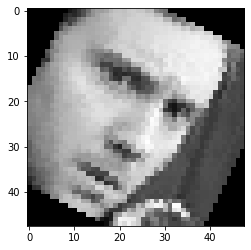

In [5]:
# transforms 한 후 변화
rotate_transform = transforms.RandomRotation(30)
after_trans = rotate_transform(before_trans.unsqueeze(0))
plt.imshow(after_trans.squeeze(), cmap='gray')

In [6]:
# Step 3. Create Model Class ./FER_model.py
# Step 4. Instantiate Model Class
model = FER_CNN()
if devices_id == type([]):  # -> GPU
    model = nn.DataParallel(model, device_ids=devices_id).cuda()
else:
    model = nn.DataParallel(model, device_ids=[devices_id]).cuda()

# 임의의 학습 이미지를 가져와서 텐서보드에 계산 그래프 추가
dataiter = iter(train_loader)
images, _ = dataiter.next()
writer.add_graph(model, images)

# Step 5. Instantiate Loss Class
criterion = torch.nn.CrossEntropyLoss()  # computes softmax and then the cross entropy
# Step 6. Instantiate Optimizer Class
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
# Step 7. Train Model
epochs = 300

loss = 0
total_iter = 0

for epoch in range(int(epochs)):
    iter = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(devices_id)
        labels = labels.to(devices_id)
        optimizer.zero_grad()

        outputs = model(images)
        # Calc loss
        loss = criterion(outputs, labels)
        # Back-propagation
        loss.backward()
        # Updating wegihts
        optimizer.step()
        
        total_iter += 1
        iter += 1
        if iter % 100 == 0:
            writer.add_scalar('Train/Loss', loss, total_iter)

            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(devices_id)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                predicted = predicted.cpu()
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / total
            print(
                f"[Epoch {epoch}] [Iteration: {i:03d}/{len(train_loader)}] [Loss: {loss.item():.3f}] [Accuracy: {accuracy:.2f}]"
            )

writer.close()

on: 099/288] [Loss: 0.907] [Accuracy: 60.77]
[Epoch 146] [Iteration: 199/288] [Loss: 0.906] [Accuracy: 60.16]
[Epoch 147] [Iteration: 099/288] [Loss: 0.908] [Accuracy: 60.56]
[Epoch 147] [Iteration: 199/288] [Loss: 1.001] [Accuracy: 59.64]
[Epoch 148] [Iteration: 099/288] [Loss: 0.968] [Accuracy: 60.34]
[Epoch 148] [Iteration: 199/288] [Loss: 0.808] [Accuracy: 60.39]
[Epoch 149] [Iteration: 099/288] [Loss: 0.903] [Accuracy: 60.73]
[Epoch 149] [Iteration: 199/288] [Loss: 1.015] [Accuracy: 60.39]
[Epoch 150] [Iteration: 099/288] [Loss: 0.803] [Accuracy: 60.09]
[Epoch 150] [Iteration: 199/288] [Loss: 0.928] [Accuracy: 60.50]
[Epoch 151] [Iteration: 099/288] [Loss: 0.836] [Accuracy: 60.87]
[Epoch 151] [Iteration: 199/288] [Loss: 0.920] [Accuracy: 60.07]
[Epoch 152] [Iteration: 099/288] [Loss: 0.838] [Accuracy: 60.91]
[Epoch 152] [Iteration: 199/288] [Loss: 1.003] [Accuracy: 59.85]
[Epoch 153] [Iteration: 099/288] [Loss: 0.868] [Accuracy: 60.91]
[Epoch 153] [Iteration: 199/288] [Loss: 0.959